In [1]:
import numpy as np
import pickle
from tqdm import tqdm
import simtk.openmm as mm
import simtk.openmm.app as app
import simtk.unit as unit

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
num_particles = 1000000
mass = 180.15 * unit.amu # masa de la glucosa

In [3]:
temperature = 300*unit.kelvin
friction = 10.0/unit.picosecond # Damping del Langevin

In [4]:
# Condiciones iniciales

initial_positions  = np.zeros([num_particles, 3], np.float32) * unit.angstroms
initial_velocities = np.zeros([num_particles, 3], np.float32) * unit.angstroms/unit.picoseconds

In [5]:
system = mm.System()

In [6]:
for ii in range(num_particles):
    system.addParticle(mass)

In [7]:
# Parámetros de la simulación.

step_size = 0.1*unit.picoseconds
steps_per_period = 100
num_periods = 5000
trajectory_file = '1_free_particle_300K_10Fric.pkl'


In [8]:
# Creación del integrador.

integrator = mm.LangevinIntegrator(temperature, friction, step_size)


In [11]:
# Creación de la plataforma.

platform_name = 'CPU'
platform = mm.Platform.getPlatformByName(platform_name)

In [12]:
context = mm.Context(system, integrator, platform)
context.setPositions(initial_positions)
context.setVelocities(initial_velocities)

In [13]:
times = np.zeros([num_periods], np.float32) * unit.picoseconds
positions = np.zeros([num_periods, num_particles, 3], np.float32) * unit.angstroms
velocities = np.zeros([num_periods, num_particles, 3], np.float32) * unit.angstroms/unit.picosecond

In [14]:
# Almacenamiento en reporteros de las condiciones iniciales para tiempo 0

state = context.getState(getPositions=True, getVelocities=True)
times[0] = state.getTime()
positions[0] = state.getPositions()
velocities[0] = state.getVelocities()


In [15]:
for ii in tqdm(range(1,num_periods)):
    context.getIntegrator().step(steps_per_period)
    state = context.getState(getPositions=True, getVelocities=True)
    times[ii] = state.getTime()
    positions[ii] = state.getPositions()
    velocities[ii] = state.getVelocities()


100%|██████████| 4999/4999 [04:57<00:00, 16.78it/s]


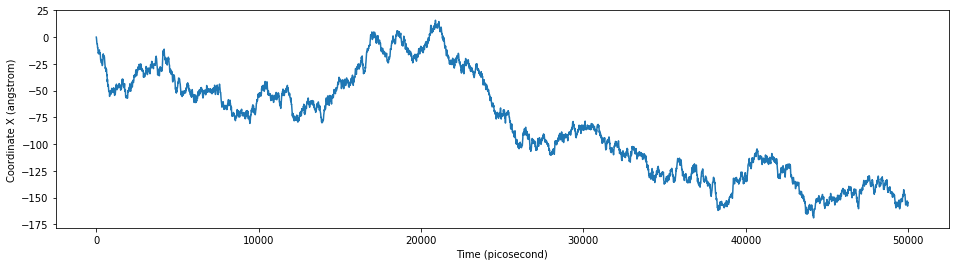

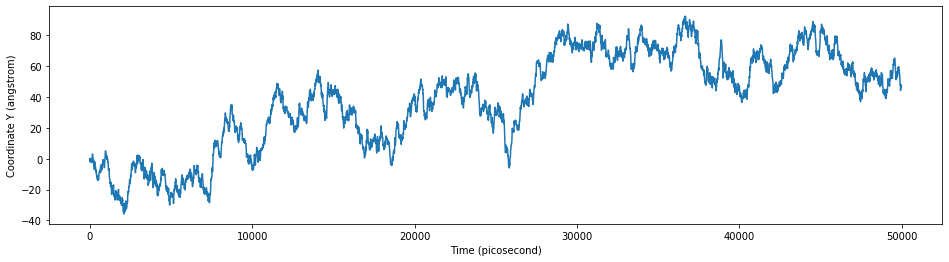

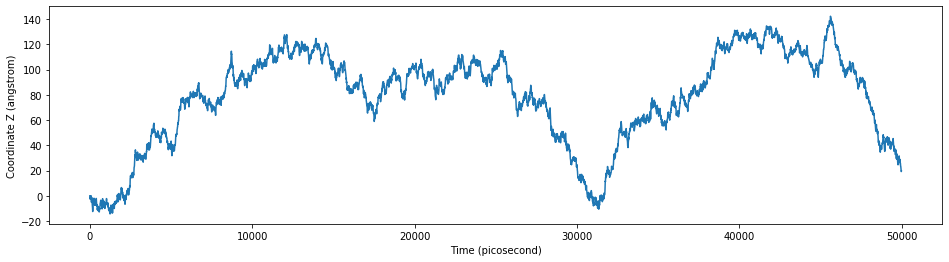

In [17]:
plt.rcParams['figure.figsize'] = [16, 4]

plt.plot(times, positions[:,0,0])
plt.xlabel('Time ({})'.format(times.unit))
plt.ylabel('Coordinate X ({})'.format(positions.unit))
plt.show()

plt.plot(times, positions[:,0,1])
plt.xlabel('Time ({})'.format(times.unit))
plt.ylabel('Coordinate Y ({})'.format(positions.unit))
plt.show()

plt.plot(times, positions[:,0,2])
plt.xlabel('Time ({})'.format(times.unit))
plt.ylabel('Coordinate Z ({})'.format(positions.unit))
plt.show()

In [18]:
def incremento(trayectoria, coordenada, paso):
    
    frames = trayectoria.shape[0]
    cajon = []
    for ii in range(0,frames-paso):
        delta = trayectoria[ii+paso,0,coordenada] - trayectoria[ii,0,coordenada]
        cajon.append(delta._value)

    return np.array(cajon)

In [19]:
incrementos_x_1 = incremento(positions,0,1)
incrementos_x_5 = incremento(positions,0,5)
incrementos_x_10 = incremento(positions,0,10)
incrementos_x_50 = incremento(positions,0,50)
incrementos_x_100 = incremento(positions,0,100)
incrementos_x_500 = incremento(positions,0,500)

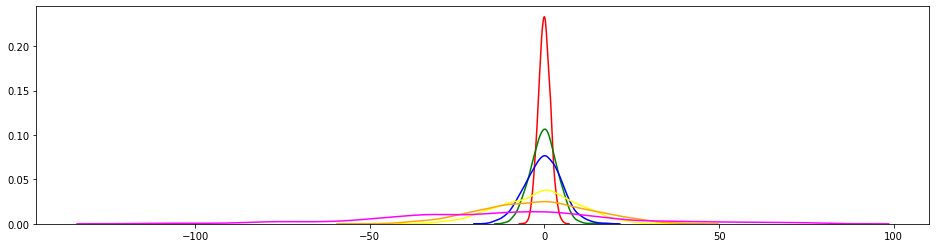

In [22]:
sns.distplot(incrementos_x_1, bins = 100, norm_hist = True, hist =  False, color = 'red')
sns.distplot(incrementos_x_5, bins = 100, norm_hist = True, hist =  False, color = 'green')
sns.distplot(incrementos_x_10, bins = 100, norm_hist = True, hist =  False, color = 'blue')
sns.distplot(incrementos_x_50, bins = 100, norm_hist = True, hist =  False, color = 'yellow')
sns.distplot(incrementos_x_100, bins = 100, norm_hist = True, hist =  False, color = 'orange')
sns.distplot(incrementos_x_500, bins = 100, norm_hist = True, hist =  False, color = 'magenta')

In [23]:
std_x_1 = incrementos_x_1.std()
std_x_5 = incrementos_x_5.std()
std_x_10 = incrementos_x_10.std()
std_x_50 = incrementos_x_50.std()
std_x_100 = incrementos_x_100.std()
std_x_500 = incrementos_x_500.std()

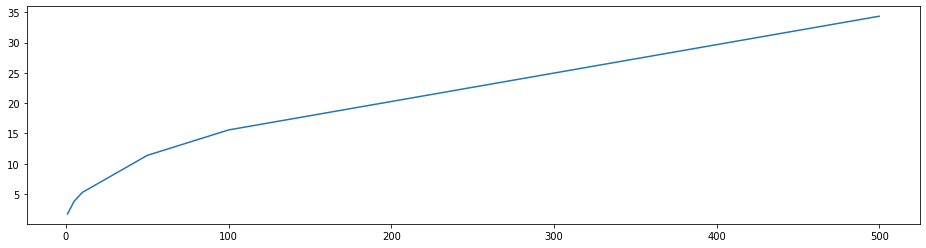

In [24]:
plt.plot([1,5,10,50,100,500],[std_x_1,std_x_5,std_x_10,std_x_50,std_x_100,std_x_500])

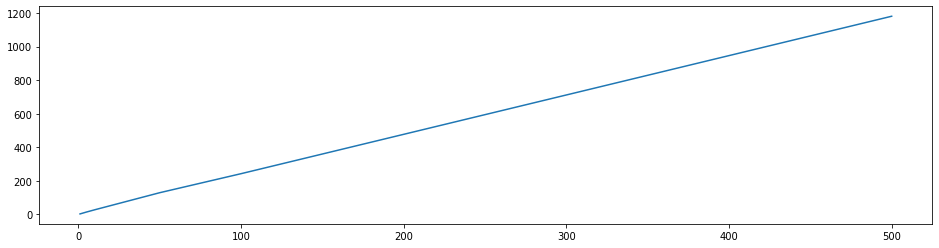

In [25]:
pasos = np.array([1,5,10,50,100,500])
stds = np.array([std_x_1,std_x_5,std_x_10,std_x_50,std_x_100,std_x_500])
plt.plot(pasos,stds**2)